In [367]:
import pandas as pd
from datetime import datetime
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tarfile
import os



In [368]:
time_interval = '31T' # we group trades on 15 minutes intervals
N = 10 # number of days
T = 100 # number of stocks

In [369]:
import tarfile
import pandas as pd

# Define the path to the tar file
tar_file_path = 'data/period_data.tar'

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Iterate through each member in the tar file
    for member in tar.getmembers():
        # Check if the file is a .parquet file
        if member.isfile() and member.name.endswith('.parquet'):
            # Extract the file
            extracted_file = tar.extractfile(member)
            if extracted_file:
                # Load the parquet file into a DataFrame
                daily_df = pd.read_parquet(extracted_file)
                # Reset the index and keep it as a column
                daily_df.reset_index(inplace=True)
                # Append to the combined DataFrame
                combined_df = pd.concat([combined_df, daily_df], ignore_index=True)

# Print the combined DataFrame's shape and a preview
print(combined_df.shape)
combined_df.head()


(4133618, 6)


,xltime,bid_price,bid_volume,ask_price,ask_volume,ticker
0,2012-03-01 09:30:00-05:00,40.934394,178,41.132879,525,CORN
1,2012-03-01 09:31:00-05:00,40.972564,72,41.120000,150,CORN
2,2012-03-01 09:32:00-05:00,40.995385,25,41.117692,157,CORN
3,2012-03-01 09:33:00-05:00,41.008200,100,41.107200,362,CORN
4,2012-03-01 09:35:00-05:00,40.974000,25,41.108000,175,CORN


Load the train and val files, merge them, keep only data before 4pm and add a log return column

In [370]:
filtered_df = combined_df[combined_df['xltime'].dt.time < datetime.strptime('16:00', '%H:%M').time()]
filtered_df["Date"] = filtered_df["xltime"].dt.date

filtered_df['log-return'] = np.log(filtered_df['ask_price']).diff()
filtered_df['log-return'] = filtered_df['log-return'].apply(lambda x: 0 if abs(x) > 10 else x)
filtered_df = filtered_df.dropna(subset=['log-return'])
filtered_df

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\4294609877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = filtered_df["xltime"].dt.date
c:\Users\phlev\AppData\Roaming\Python\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\4294609877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log-return'] = np.log(filtered

,xltime,bid_price,bid_volume,ask_price,ask_volume,ticker,Date,log-return
1,2012-03-01 09:31:00-05:00,40.972564,72,41.120000,150,CORN,2012-03-01,-0.000313
2,2012-03-01 09:32:00-05:00,40.995385,25,41.117692,157,CORN,2012-03-01,-0.000056
3,2012-03-01 09:33:00-05:00,41.008200,100,41.107200,362,CORN,2012-03-01,-0.000255
4,2012-03-01 09:35:00-05:00,40.974000,25,41.108000,175,CORN,2012-03-01,0.000019
5,2012-03-01 09:37:00-05:00,40.972857,26,41.100000,20,CORN,2012-03-01,-0.000195
...,...,...,...,...,...,...,...,...
4133613,2012-12-31 15:55:00-05:00,47.417671,55952,47.428298,120881,XLY,2012-12-31,0.000264
4133614,2012-12-31 15:56:00-05:00,47.386378,161080,47.396953,227951,XLY,2012-12-31,-0.000661
4133615,2012-12-31 15:57:00-05:00,47.352095,55767,47.363543,131497,XLY,2012-12-31,-0.000705
4133616,2012-12-31 15:58:00-05:00,47.370508,67879,47.381836,147840,XLY,2012-12-31,0.000386


In [371]:
filtered_df['xltime']

1         2012-03-01 09:31:00-05:00
2         2012-03-01 09:32:00-05:00
3         2012-03-01 09:33:00-05:00
4         2012-03-01 09:35:00-05:00
5         2012-03-01 09:37:00-05:00
                     ...           
4133613   2012-12-31 15:55:00-05:00
4133614   2012-12-31 15:56:00-05:00
4133615   2012-12-31 15:57:00-05:00
4133616   2012-12-31 15:58:00-05:00
4133617   2012-12-31 15:59:00-05:00
Name: xltime, Length: 4133563, dtype: datetime64[ns, America/New_York]

Create the dataframe: basically a table with each columns as days, each row as a stock logreturn on a designated interval

In [372]:

filtered_df['Floored_Timestamp'] = filtered_df['xltime'].dt.floor(time_interval) # Floor the timestamp to the nearest time_interval minutes
# add a column with stock and new timestamp for merging
filtered_df['Stock_Timestamp'] = filtered_df['ticker'] + "_" + filtered_df['Floored_Timestamp'].dt.strftime('%H:%M:%S.%f')

grouped_df = filtered_df.pivot_table(index='Stock_Timestamp', columns='Date', values='log-return', aggfunc='mean')
grouped_df = grouped_df.fillna(0)

print(grouped_df.shape)
grouped_df.head()


(23520, 211)


Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Stock_Timestamp,,,,,,,,,,,,,,,,,,,,,
CORN_09:00:00.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055816
CORN_09:01:00.000000,0.0,0.0,0.0,0.0,-0.022715,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CORN_09:02:00.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CORN_09:03:00.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CORN_09:04:00.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-0.046184,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [373]:
#create correlation dataframe between days
corr = grouped_df.corr()
corr.head()

Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,1.000000,-0.000034,-0.000039,-0.000049,-0.000004,-0.000041,-0.000020,-0.000051,-0.000034,-0.000048,...,-0.000035,-0.000032,-0.000045,-0.000033,-0.000038,-0.000031,-0.000029,-0.000036,-0.000028,-3.409386e-06
2012-03-02,-0.000034,1.000000,-0.000031,-0.000039,-0.000003,-0.000032,-0.000016,-0.000040,-0.000027,-0.000039,...,-0.000028,-0.000025,-0.000036,-0.000026,-0.000030,-0.000025,-0.000023,-0.000029,-0.000023,-2.718206e-06
2012-03-05,-0.000039,-0.000031,1.000000,-0.000044,-0.000003,-0.000037,-0.000018,-0.000045,-0.000031,-0.000044,...,-0.000031,-0.000029,-0.000040,-0.000029,-0.000034,-0.000028,-0.000026,-0.000033,-0.000026,-3.065543e-06
2012-03-06,-0.000049,-0.000039,-0.000044,1.000000,-0.000004,-0.000047,-0.000023,-0.000058,-0.000039,-0.000056,...,-0.000040,-0.000037,-0.000051,-0.000038,-0.000044,-0.000035,-0.000033,-0.000042,-0.000033,-3.913143e-06
2012-03-07,-0.000004,-0.000003,-0.000003,-0.000004,1.000000,-0.000004,-0.000002,-0.000004,-0.000003,-0.000004,...,-0.000003,-0.000003,-0.000004,-0.000003,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-2.977598e-07


Louvain Clustering

In [374]:
# process data for louvain clustering
def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v

l, v = get_sortest_eig(corr)

lambda_limit = 1e-1
len(l[l<lambda_limit]) 
selected_indices = [i for i, l in enumerate(l) if l <= lambda_limit]

C_r = np.zeros_like(corr)

for i in selected_indices:
    v_i = v[:, i]  # Get the i-th eigenvector
    outer_product = np.outer(v_i, v_i)  # Compute outer product
    C_r += l[i] * outer_product  # Add scaled matrix to the sum

C_m = l[-1] * np.outer(v[-1, :],v[-1, :])
C_0 = C_r + C_m
C = abs(corr - C_0)
G = nx.from_pandas_adjacency(C)


In [375]:
# partition using louvain clustering
partition = community_louvain.best_partition(G)
print(len(partition))
print(partition)

211
{datetime.date(2012, 3, 1): 0, datetime.date(2012, 3, 2): 1, datetime.date(2012, 3, 5): 2, datetime.date(2012, 3, 6): 3, datetime.date(2012, 3, 7): 4, datetime.date(2012, 3, 8): 14, datetime.date(2012, 3, 9): 14, datetime.date(2012, 3, 12): 7, datetime.date(2012, 3, 13): 8, datetime.date(2012, 3, 14): 9, datetime.date(2012, 3, 15): 10, datetime.date(2012, 3, 16): 11, datetime.date(2012, 3, 19): 12, datetime.date(2012, 3, 20): 13, datetime.date(2012, 3, 21): 14, datetime.date(2012, 3, 22): 15, datetime.date(2012, 3, 23): 16, datetime.date(2012, 3, 26): 17, datetime.date(2012, 3, 27): 18, datetime.date(2012, 3, 28): 19, datetime.date(2012, 3, 29): 20, datetime.date(2012, 3, 30): 21, datetime.date(2012, 4, 2): 1, datetime.date(2012, 4, 3): 22, datetime.date(2012, 4, 4): 23, datetime.date(2012, 4, 5): 2, datetime.date(2012, 4, 9): 14, datetime.date(2012, 4, 10): 24, datetime.date(2012, 4, 11): 25, datetime.date(2012, 4, 12): 7, datetime.date(2012, 4, 13): 8, datetime.date(2012, 4, 16):

Quick cell to display total logreturns of each cluster

In [376]:
# Convert partition to a dataframe
partition_df = pd.DataFrame(list(partition.items()), columns=['Date', 'Cluster'])

# Merge log return data with cluster assignments
log_return_clustered = filtered_df.merge(partition_df, on='Date')
log_return_clustered.groupby('Cluster')["log-return"].sum()


Cluster
0     0.035585
1    -1.497381
2     0.024389
3    -0.045137
4    -0.004444
5     0.070128
6    -0.014910
7     0.010858
8     0.048506
9     0.023569
10    0.006495
11   -0.030968
12   -0.014828
13    3.806217
14   -0.031670
15   -1.452940
16   -0.021660
17    0.026375
18    0.032245
19    0.017630
20   -0.011201
21   -0.018408
22   -0.008648
23    0.004328
24   -0.042801
25    0.039522
26    0.016730
27   -0.005157
28   -0.022135
Name: log-return, dtype: float64

Number of clusters

In [377]:
# how many clusters
num_clusters = len(set(partition.values()))
num_clusters

29

Clustering visualization

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


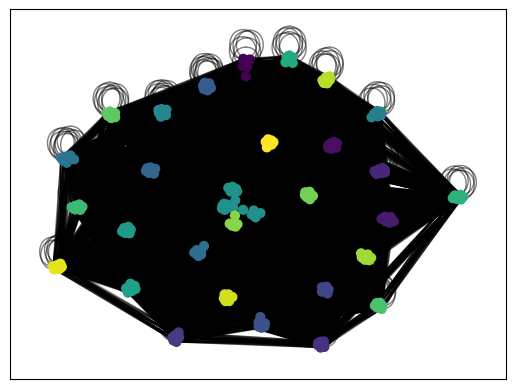

In [378]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()